<a href="https://colab.research.google.com/github/Lutris98/21_1Q/blob/master/Titanic_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.EDA

In [440]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #model_selection doesn't need mentioning, only the method does
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score #given metric was accuracy


In [441]:
from google.colab import drive #Korean Army banned me from using os resources so I learned new ways
drive.mount('/content/gdrive')
titanic_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/titanic_train.csv') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [442]:
from google.colab import drive 
drive.mount('/content/gdrive')
test_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/titanic_test.csv') 
test_df.info()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [443]:
df=pd.concat([titanic_df,test_df],axis=0) #concatenating method in Pandas #Preprocessing needs test data(Never modeling) #Null values are okay until padding

##1)Basic Statistics

In [444]:
df.head(3) 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [445]:
df.info() #objects are strings

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [446]:
df['Fare']=df.fillna(df['Fare'].mean())

##2)Dropping&Creating features

In [447]:
df['Family']=df['SibSp']+df['Parch'] #Each feature doesn't mean much on its own
df['Name']=df['Name'].str.extract('([A-Za-z]+)\.') #easiest Regex([] contains letters, +groups the previous part, ()contains part to be remembered, \ignores that . mean any letters)
df=df.drop(['PassengerId','SibSp','Parch','Ticket'], axis=1) #drop method doesn't allow inplacing(Should check results along the way)
df['Name'].value_counts(sort=True) #Even the most worthless data needs a peak

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Ms            2
Mlle          2
Countess      1
Mme           1
Capt          1
Jonkheer      1
Sir           1
Lady          1
Dona          1
Don           1
Name: Name, dtype: int64

In [448]:
df['Name'].replace(['Rev','Dr','Col','Major','Sir','Don','Mlle','Jonkheer','Mme','Ms','Countess','Capt','Lady','Dona'],['Mr','Mr','Mr','Mr','Mr','Mr','Mr','Mr','Mr','Miss','Miss','Miss','Miss','Miss',],inplace=True) #last3 of Mr is just guessing
df['Name'].value_counts(sort=True)

Mr        785
Miss      266
Mrs       197
Master     61
Name: Name, dtype: int64

##3)Encoding

In [449]:
for feature in ['Sex', 'Cabin', 'Embarked']:
  print(df[feature].value_counts(sort=True)) #focusing on columns

male      843
female    466
Name: Sex, dtype: int64
C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
D                  4
C78                4
                  ..
E63                1
C99                1
B37                1
A19                1
C87                1
Name: Cabin, Length: 186, dtype: int64
S    914
C    270
Q    123
Name: Embarked, dtype: int64


In [450]:
df['Cabin']=df['Cabin'].str[:1] #Cabin needs insight that only the first character contains information #pd.str is applicable to series
features=['Cabin','Sex','Embarked']
for feature in features:
  df[feature]=LabelEncoder().fit_transform(df[feature].astype(str)) #changing dtype of series

1. Distribution
2. Correlation
3. Impacts on target
4. Train&test similarity

In [451]:
df.head(3)

,Survived,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,Family
0,0.0,3,Mr,1,22.0,1,8,2,1
1,1.0,1,Mrs,0,38.0,2,2,0,1
2,1.0,3,Miss,0,26.0,3,8,2,0


#2.Preprocessing(with Visualization)

##1)Padding

In [452]:
def count_plot(dataframe, feature, hue=None): #distribution of feature itself #Non-necessary values need initialization to none
  f,ax=plt.subplots(figsize=(10,5))
  sns.countplot(data=dataframe, x=feature, hue=hue)
  plt.show()
def bar_plot(dataframe, feature1, feature2, hue=None): #distribution of feature with another
  f,ax=plt.subplots(figsize=(10,5))
  sns.barplot(data=dataframe, x=feature1, y=feature2, hue=hue)
  plt.show()
def dist_plot(dataframe, feature1, feature2=None):
  f,ax=plt.subplots(figsize=(10,5))
  sns.displot(data=dataframe, x=feature1, y=feature2) #there is no 't'
  plt.show()

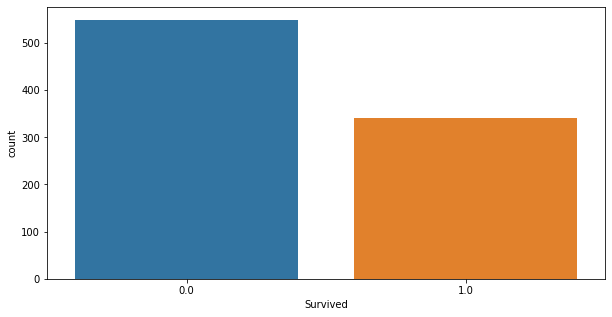

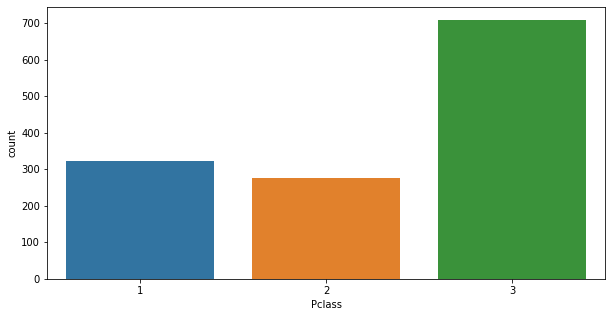

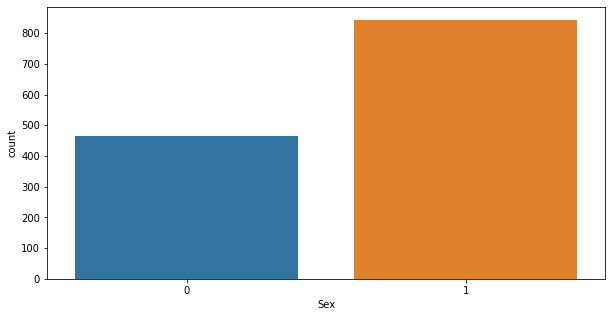

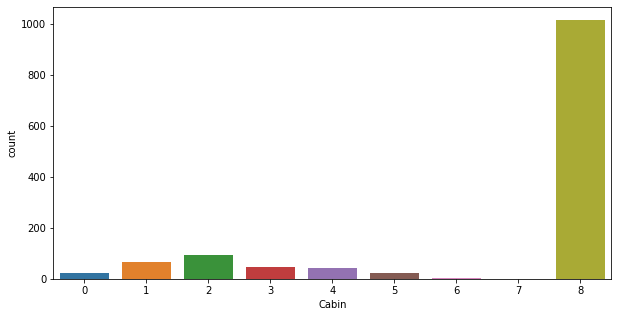

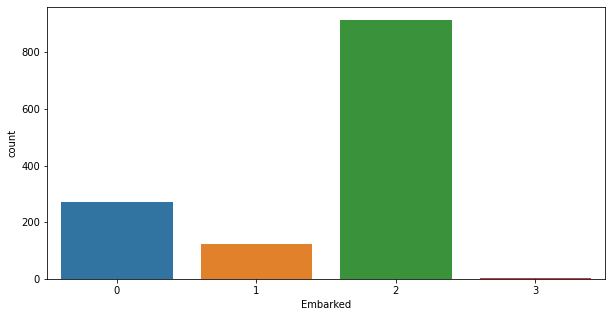

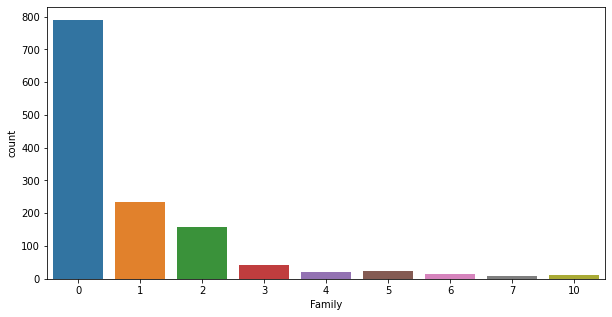

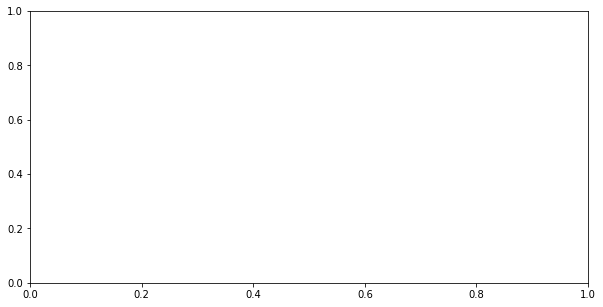

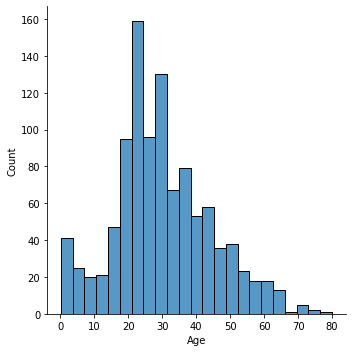

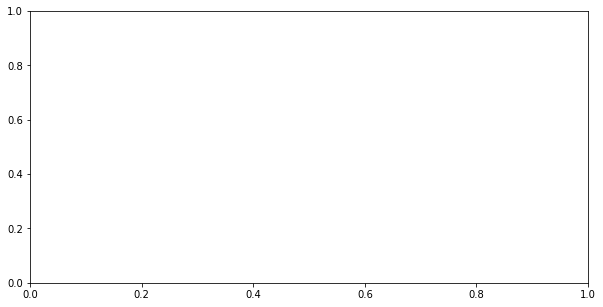

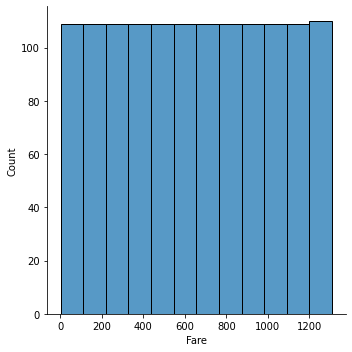

In [453]:
features_int=df.columns.drop(labels=['Name','Age','Fare']).values #columns is dataframe, so make it into ndarray #when simply writing is unwanted, try finding the parameter 
features_float=['Age','Fare']
for feature in features_int:
  count_plot(df, feature)
for feature in features_float:
  dist_plot(df, feature)

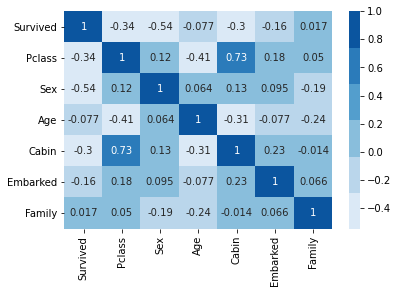

In [454]:
cmap=sns.color_palette('Blues') #I don't know each color
sns.heatmap(df.corr(), annot=True, cmap=cmap) #annotatiion is a must

In [455]:
df.isna().sum()

Survived    418
Pclass        0
Name          0
Sex           0
Age         263
Fare          0
Cabin         0
Embarked      0
Family        0
dtype: int64

In [456]:
df.loc[(df.Age.isnull())&(df.Name=='Mr'),'Age']=30 #Another way to load series object #inside []are all true
df.loc[(df.Age.isnull())&(df.Name=='Mrs'),'Age']=30
df.loc[(df.Age.isnull())&(df.Name=='Miss'),'Age']=20
df.loc[(df.Age.isnull())&(df.Name=='Master'),'Age']=5

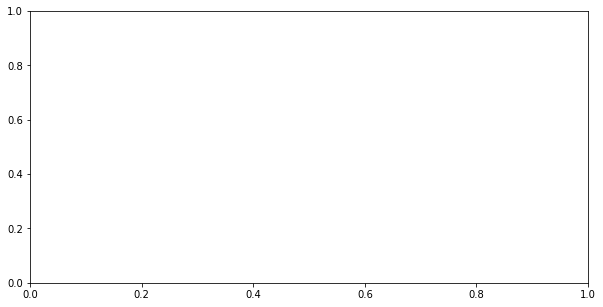

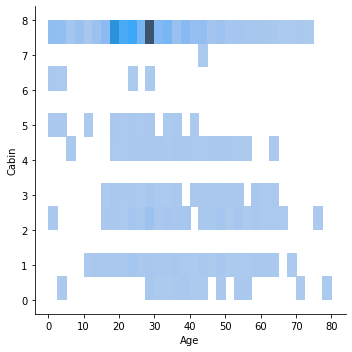

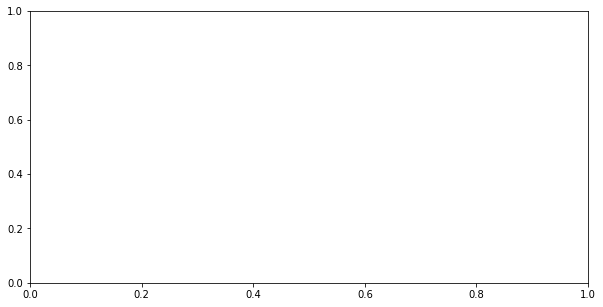

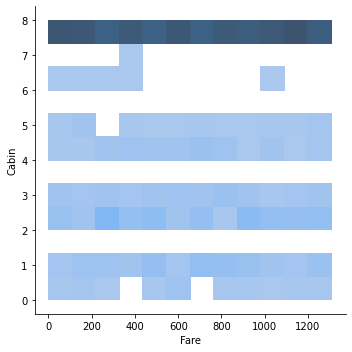

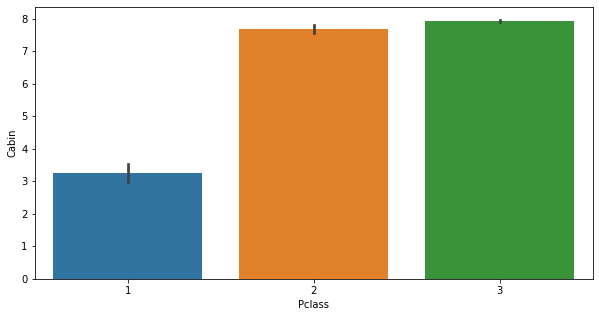

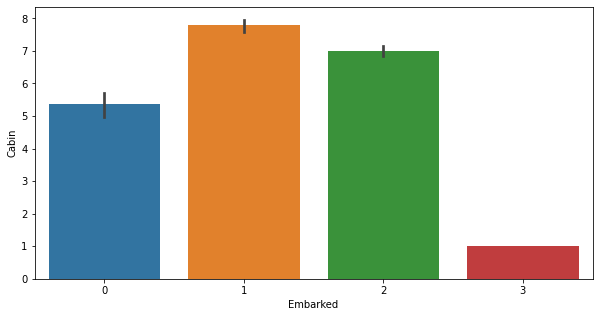

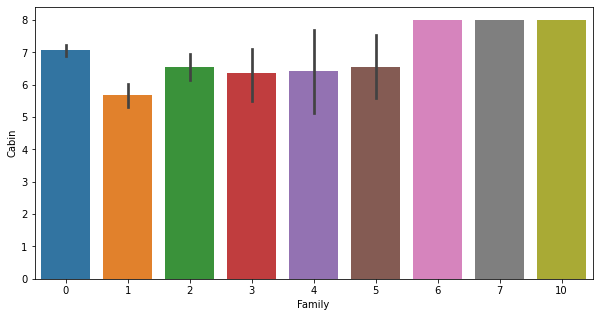

In [457]:
features_float=['Age','Fare']
features_int=['Pclass','Embarked','Family']
for feature in features_float:
  dist_plot(df,feature1=feature, feature2='Cabin') #How???
for feature in features_int:
  bar_plot(df,feature1=feature, feature2='Cabin')

##2)Scaling&Outliers

In [ ]:
df. #classification rarely needs scaling

##3)Continuous to Labels(Classification only)

#3.CV&Tuning

In [132]:
test_df=df.loc[df['Survived']==2].drop('Survived',axis=1) #Needs division again
titanic_df=df.loc[df['Survived']!=2]
titanic_feature=titanic_df.drop(['Survived'], axis=1) #parameter axis is mandatory
titanic_label=titanic_df['Survived'] 

In [16]:
rf_clf=RandomForestClassifier(random_state=0) #Cross validation need models 
xgb_clf=XGBClassifier(random_state=0)
lgbm_clf=LGBMClassifier(random_state=0)
X_train, X_test, y_train, y_test=train_test_split(titanic_feature, titanic_label, test_size=0.2,random_state=0)

In [17]:
rf_params={'n_estimators':[300],
           'max_depth':[6,8,10,12], #similar to decisiontree
           'min_samples_leaf':[3,5,7],
           'min_samples_split':[10,15,20]}
rf_gridcv=GridSearchCV(rf_clf, param_grid=rf_params, cv=5, n_jobs=-1) #using all CPU cores
rf_gridcv.fit(X_train, y_train)
print('best parameters:\n',rf_gridcv.best_params_)

best parameters:
 {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}


In [18]:
xgb_params={'learning_rate' : [0.02], 
            'n_estimators':[200,300,400],
            'max_depth':[3,5,7],
            'colsample_bytree':[0.7,0.8],
            'subsample':[0.9]}
xgb_gridcv=GridSearchCV(xgb_clf, param_grid=xgb_params, cv=5, n_jobs=-1) 
xgb_gridcv.fit(X_train, y_train)
print('best parameters:\n',xgb_gridcv.best_params_)

best parameters:
 {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}


In [19]:
lgbm_params={'learning_rate' : [0.02], 
            'n_estimators':[200,300,400],
            'max_depth':[8,10,12],
            'num_leaves':[50],
            'colsample_bytree':[0.7,0.8],
            'subsample':[0.9]}
lgbm_gridcv=GridSearchCV(lgbm_clf, param_grid=lgbm_params, cv=5, n_jobs=-1) 
lgbm_gridcv.fit(X_train, y_train)
print('best parameters:\n',lgbm_gridcv.best_params_)

best parameters:
 {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 12, 'n_estimators': 200, 'num_leaves': 50, 'subsample': 0.9}


#4.Modeling

In [20]:
rf_clf=rf_gridcv.best_estimator_
xgb_clf=xgb_gridcv.best_estimator_
lgbm_clf=lgbm_gridcv.best_estimator_
vo_clf=VotingClassifier(estimators=[('RandomForest',rf_clf),('XGBoost',xgb_clf),('LightGBM',lgbm_clf)], voting='soft')
vo_clf.fit(X_train, y_train)
pred1=rf_clf.fit(X_train, y_train).predict(X_test)
pred2=xgb_clf.fit(X_train, y_train).predict(X_test)
pred3=lgbm_clf.fit(X_train, y_train).predict(X_test)
pred4=vo_clf.predict(X_test)
print('Accuracy1:{0:.4f} Accuracy2:{1:.4f} Accuracy3:{2:4f}'.format(accuracy_score(y_test,pred1), accuracy_score(y_test,pred2),accuracy_score(y_test,pred3)))
print('Final accuracy:{0:.4f}'.format(accuracy_score(y_test,pred4))) #from python3.6 should use fstring formatting  #:separates index and the number

Accuracy1:0.8212 Accuracy2:0.8715 Accuracy3:0.837989
Final accuracy:0.8492


# 1)Uploading

In [22]:
Pid=test_df['PassengerId']
test_df.head(3)

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
0,3,1,34.5,7.8292,7,1,0
1,3,0,47.0,7.0000,7,2,1
2,2,1,62.0,9.6875,7,1,0


In [23]:
realpred=vo_clf.predict(test_df) #output of classifier is ndarray object
realpred=pd.DataFrame(realpred, columns=['Survived']) #never forget[]
Submit=pd.DataFrame({'PassengerId':Pid,'Survived':realpred['Survived']}) #Data set by giving each column name and data
Submit.head(3)
Submit.to_csv('/content/gdrive/MyDrive/Dataset/Lutris_titanic.csv', index = False) #The client doesn't want indice on submission

# 2)Feedback<br>


#3)Afterwords
3.2.'21 SibSp and Parch doesn't mean much on their own
4.2.'21 concatenation Cabin looks appropriate to display wealth(high correlation with Pclass and more labels